In [1]:
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

In [2]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:

class UnlabeledColorizationDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_paths = os.listdir(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_paths[idx])
        color_image = Image.open(img_path)

        # Convert the color image to RGB format (3 channels)
        color_image = color_image.convert('RGB')

        if self.transform:
            color_image = self.transform(color_image)

        transform = transforms.Grayscale(num_output_channels=1)
        grayscale_image = transform(color_image)

        return grayscale_image, color_image


torch.Size([1, 224, 224])
torch.Size([3, 224, 224])


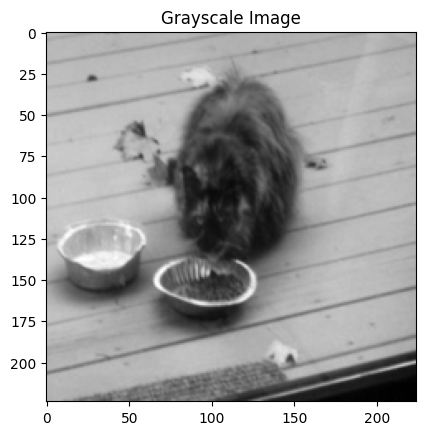

In [5]:
unlabeled_data = UnlabeledColorizationDataset('/home/rishabh.mondal/ssl_dataset/', transform=transform)
len(unlabeled_data)
#show the image
grayscale_image, color_image = unlabeled_data[0]
plt.imshow(grayscale_image.squeeze(), cmap='gray')
plt.title('Grayscale Image')
#show the dimension of the image
print(grayscale_image.shape)
print(color_image.shape)

In [11]:
import torch.nn.functional as F

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 56 * 56, 10000)  
        self.fc11 = nn.Linear(10000,4096)# Adjusted the input size

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = F.relu(x, inplace=True)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = F.relu(x, inplace=True)
        x = self.conv3(x)
        x = F.relu(x, inplace=True)
        x = self.conv4(x)
        x = F.relu(x, inplace=True)
        x = self.flatten(x)
        x = self.fc1(x)
        x=self.fc11(x)
        return x

In [16]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc2 = nn.Linear(4096, 10000)
        self.fc21=nn.Linear(10000,16*56*56,)
        self.unflatten = nn.Unflatten(1, (16, 56, 56))
        self.conv5 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.fc2(x)
        x = F.relu(x, inplace=True)
        x=self.fc21(x)
        x = F.relu(x, inplace=True)
        x = self.unflatten(x)
        x = self.conv5(x)
        x = F.relu(x, inplace=True)
        x = self.conv6(x)
        x = F.relu(x, inplace=True)
        x = self.conv7(x)
        x = F.relu(x, inplace=True)
        x = self.conv8(x)
        print(x.shape)
        return x

In [17]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, color_image):
        x = self.encoder(color_image)
        x = self.decoder(x)
        return x

In [18]:
model = ColorizationModel()
model = model.to(device)
print(model)

ColorizationModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=50176, out_features=10000, bias=True)
    (fc11): Linear(in_features=10000, out_features=4096, bias=True)
  )
  (decoder): Decoder(
    (fc2): Linear(in_features=4096, out_features=10000, bias=True)
    (fc21): Linear(in_features=10000, out_features=50176, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(16, 56, 56))
    (conv5): Conv2d(16, 32, kernel_size=(3, 3), str

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
loss_list_ssl = []

model.train()
for epoch in range(10):
    running_loss =0.0
    for grayscale_image, color_image in unlabeled_data:
        grayscale_image, color_image = grayscale_image.to(device), color_image.to(device)
        optimizer.zero_grad()
        
        outputs = model(grayscale_image)
        loss = criterion(outputs, color_image)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(unlabeled_data)
    loss_list_ssl.append(epoch_loss)
    print('Epoch: %d | Loss: %.4f' % (epoch + 1, epoch_loss))

    


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x3136 and 50176x10000)